# Search Evaluation Notebook

This python notebook will perform a search evaluation
Prerequisites:
* Golden data set in file ```golden_data.csv```
* Search strategies in python modules located in the ```strategies``` folder

In [1]:
# Export the API key to an environment variable
import os, subprocess

openai_api_key = "YOUR KEY HERE"
openai_api_base = "https://llm-proxy.prod-3.eden.elastic.dev/v1"


os.environ["OPENAI_API_KEY"] = openai_api_key
os.environ["OPENAI_BASE_URL"] = openai_api_base

subprocess.run([
    "deepeval", "set-local-model", 
    "--model-name=gpt-4o", 
    f"--base-url={openai_api_base}", 
    f"--api-key={openai_api_key}"
    f""])

## Uncomment the following lines if you want to use .env file to control settings
# from dotenv import load_dotenv
# load_dotenv()   


In [2]:
## Run the Evaluation

from utility.util_es import get_es
from utility.util_vis_result import vis_search_eval_json, vis_deep_eval_correct_tests
from evaluate import run_evaluation, load_golden_data, load_strategies, output_eval_results

GOLDEN_DATA_CSV = "golden_data.csv"
STRATEGIES_FOLDER = "strategies"
OUTPUT_JSON = "search_evaluation_results.json"

# 1. Connect to Elasticsearch
es = get_es()
print(f"\tConnected to Elasticsearch version: {es.info()['version']['number']}")

# 2. Load the golden data set
golden_data = load_golden_data(GOLDEN_DATA_CSV)
print(f"Identified {len(golden_data)} golden data entry(ies) to use for search evaluation")

# 3. Load strategies from the strategies folder
strategy_modules = load_strategies(STRATEGIES_FOLDER)  
print(f"Identified {len(strategy_modules)} strategy(ies) to evaluate")

# 4. Evaluate each strategy
results = run_evaluation(es, golden_data, strategy_modules)

# 5. Output the evaluation results
output_eval_results(OUTPUT_JSON, results, golden_data, strategy_modules)



Using ES with configured Host and API key
	Connected to Elasticsearch version: 8.17.0
Identified 4 golden data entry(ies) to use for search evaluation
Identified 1 strategy(ies) to evaluate
### SEARCH RANK EVAL
	Starting strategy: 1_default_bm25
Evaluation complete. Results written to  search_evaluation_results.json


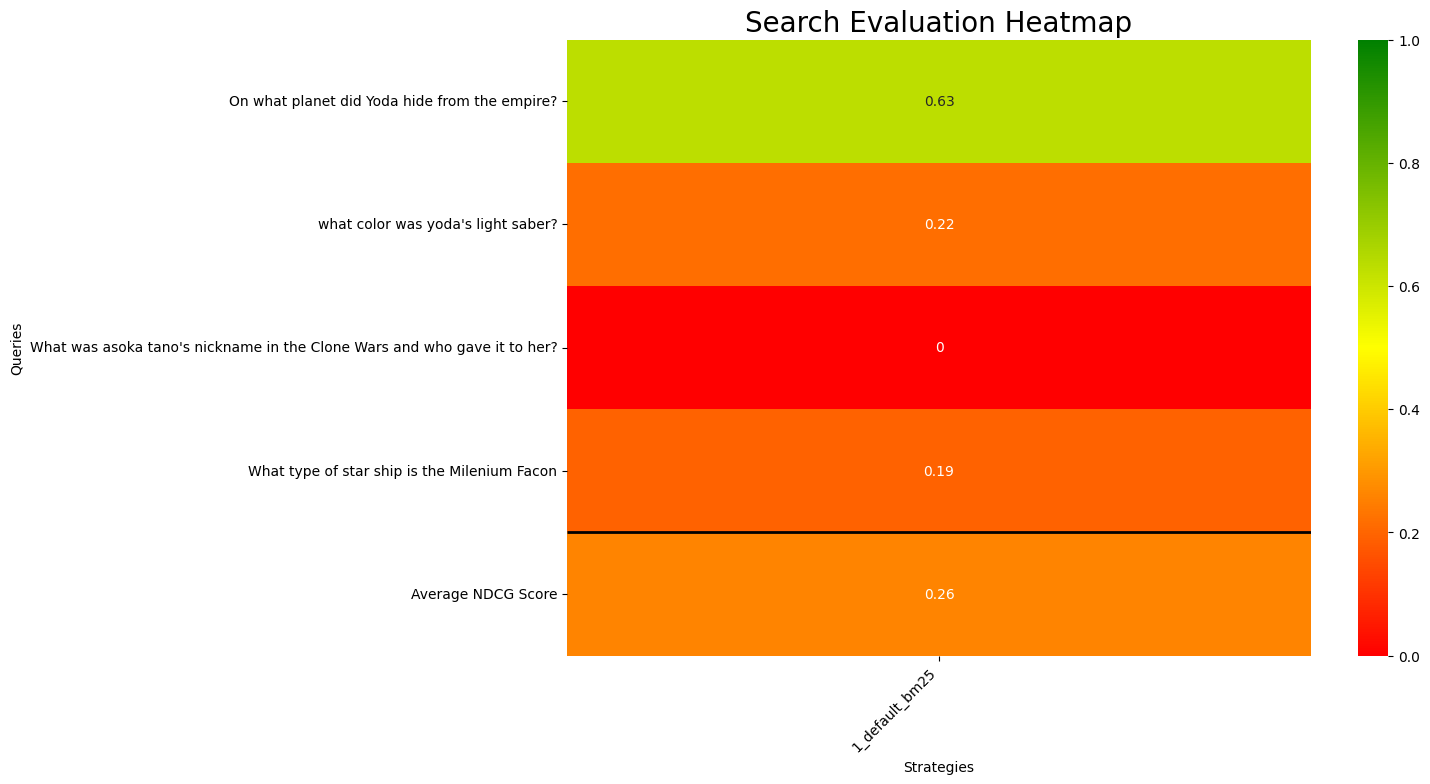

In [3]:
## Visualize the Results of the Evaluation
# 6. Visualize
vis_search_eval_json(OUTPUT_JSON)

In [4]:
from utility.util_deep_eval import generateLLMTestCase, evaluateTestCases
from deepeval.evaluate import TestResult
from utility.util_llm import LLMUtil
from utility.util_es import search_to_context
import os
import json
openai_api_key = os.getenv("OPENAI_API_KEY")

# startegies to Evauate
# include_strategy_names = ["3b_e5_hybrid", "3b_e5_hybrid_qt"]


## Deep Eval Evaluation
print("### DEEP EVAL")
deepEvalScores = {}
for strategy_name in sorted(strategy_modules.keys()):
    module = strategy_modules[strategy_name]
    llm_util = LLMUtil(openai_api_key)
    # if strategy_name not in include_strategy_names:
    #     continue

    if hasattr(module, "is_disabled") and module.is_disabled(): ## or strategy_name != "1a_bm25" :
        print(f"Skipping strategy: {strategy_name}")
        continue

    print(f"Starting strategy: {strategy_name}")
    testCases = []
    for i, item in enumerate(golden_data):
            qid = f"query_{i+1}"
            query = item["query"]


            ## correct answer from the golden data
            correct_answer = item["natural_answer"]

            ## pre-process the query string
            query_string = module.query_transform(query, llm_util,  module.get_parameters()["query_transform_prompt"]) if hasattr(module, "query_transform") else query

            ## do the RAG
            index_name = module.get_parameters()['index_name']
            body = module.build_query(query_string)
            rag_context = module.get_parameters().get("rag_context", "lore")
            

            trim_context_to_top_k_docs = 3
            trim_context_to_top_k_passages = 3

            rerank_inner_hits = module.get_parameters().get("rerank_inner_hits", False)


            retrieval_context  = search_to_context(es, index_name, query_string, body, rag_context, rerank_inner_hits, trim_context_to_top_k_docs)

            ## inner hits passages will be trim_context_to_top_k_docs * the inner hits depth ... we need to truncate
            top_context_citations = retrieval_context[:trim_context_to_top_k_passages]

            context = "\n".join([f"[{i+1}] {text}" for i, text in enumerate(top_context_citations)])
            # print(f"Context: {context}")

#             system_prompt = f"""
# Instructions:

# - You are an assistant for question-answering tasks.
# - Use the context below to answer the question.


# Context:
# {context}
# """

#             system_prompt = f"""
# Instructions:

# - You are an assistant for question-answering tasks.
# - Answer questions truthfully and factually using only the context presented.
# - If the answer is not present in the provided context, just say that you don't know rather than making up an answer or using your own knowledge from outside the prompt.
# - You are correct, factual, precise, and reliable.


# Context:
# {context}
# """

            system_prompt = f"""
Instructions:

- You are an assistant for question-answering tasks.
- Answer questions truthfully and factually using only the context presented.
- Do not jump to conclusions or make assumptions.
- If the answer is not present in the provided context, just say that you don't know rather than making up an answer or using your own knowledge from outside the prompt.
- You must always cite the document where the answer was extracted using inline academic citation style [], using the position.
- Use markdown format for code examples.
- You are correct, factual, precise, and reliable.


Context:
{context}
"""


                
            actual_output = llm_util.rag_cache(system_prompt, top_context_citations, query_string)


            ## fill in query and strategy responses in score sheet
            stratResult = {
                "actual_output": actual_output,
                "retrieval_context": [f"[{i+1}] {text}" for i, text in enumerate(top_context_citations)]
            }
            if qid not in deepEvalScores:
                deepEvalScores[qid] = { 
                    "query" : query, 
                    "correct_answer": correct_answer,
                    "strategies": { strategy_name: stratResult} }
            else:
                deepEvalScores[qid]["strategies"][strategy_name] = stratResult

            ## prep deel eval test case for later batch evaluation
            testCase = generateLLMTestCase(qid, query, actual_output, top_context_citations, correct_answer)
            testCases.append(testCase)

    ## Run evaluations for this strategy      
    rag_evaluation = evaluateTestCases(testCases)

    for test_result in  rag_evaluation.test_results:
        quid = test_result.name

        success = test_result.success
        scores = {"success": success}
        # print(f"name: {quid} | success: {success}")
        for metric in  test_result.metrics_data:
            # print(f"{metric.name} : score {metric.score} | {metric.reason}")
            scores[metric.name] = {"score": metric.score, "reason": metric.reason }
        
        deepEvalScores[quid]["strategies"][strategy_name]["scores"] = scores
    
    llm_util.flush_cache()
        
        

## save the scores to disk
# print(json.dumps(deepEvalScores, indent=2))
with open("deepeval_results.json", "w") as f:
    json.dump(deepEvalScores, f, indent=2)




### DEEP EVAL
Starting strategy: 1_default_bm25


✨ You're running DeepEval's latest Correctness (GEval) Metric! (using gpt-4o, strict=False, async_mode=True)...

Event loop is already running. Applying nest_asyncio patch to allow async execution...


Evaluating 4 test case(s) in parallel: |██████████|100% (4/4) [Time Taken: 00:00, 50.26test case/s]


✓ Tests finished 🎉! Run 'deepeval login' to save and analyze evaluation results on Confident AI. 
‼️  Friendly reminder 😇: You can also run evaluations with ALL of deepeval's metrics directly on Confident AI 
instead.

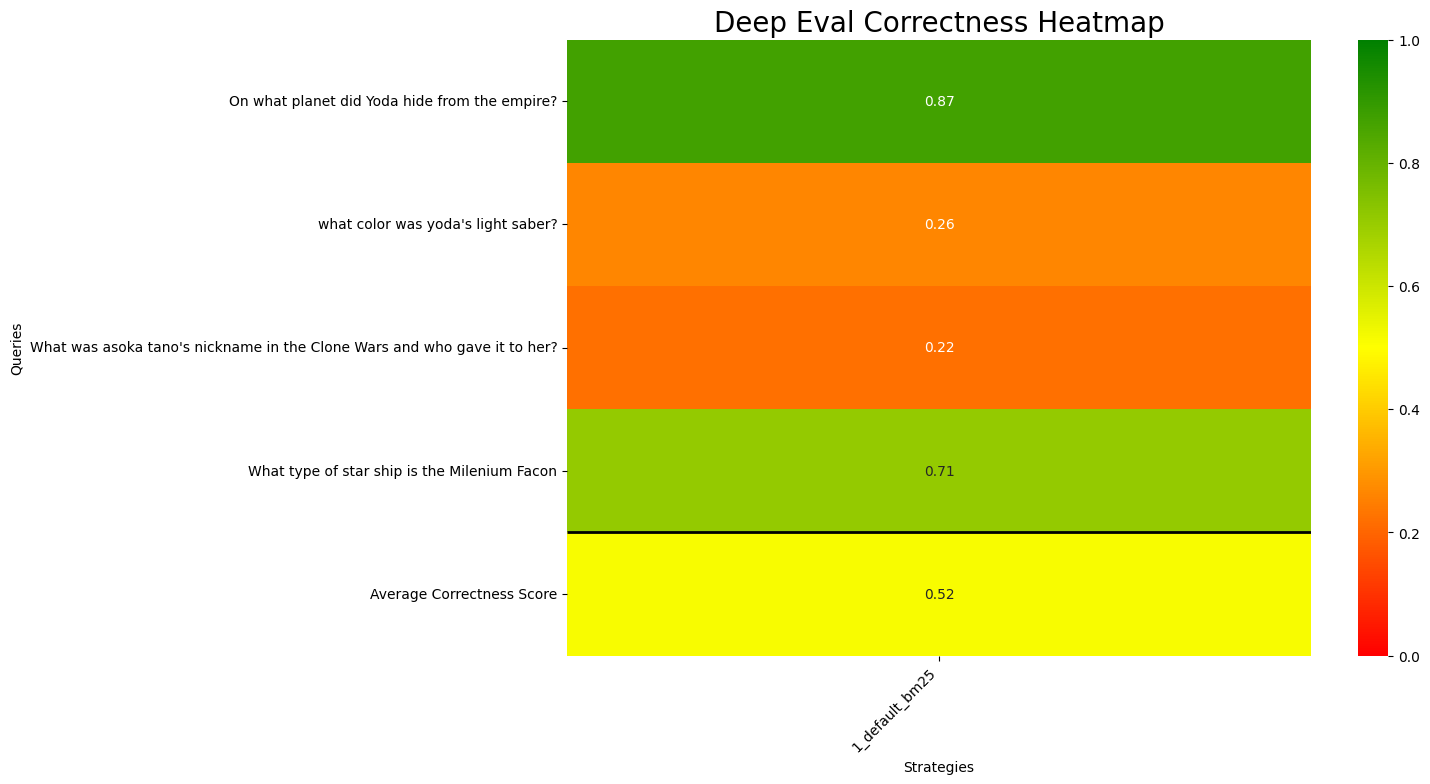

In [5]:
# 6. Visualize
vis_deep_eval_correct_tests("deepeval_results.json")